# INF8775 – Analyse et conception d’algorithmes
# TP1 – Hiver 2021

Mili, Haroun, 1234567

Denis, Simon, 1234567

Note finale :

 <u>**Date limite de remise :**</u>  21 Février 23h59 (Groupe B1), 13 février 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Les questions et tâches à effectuées sont généralement indiquées par un TODO, mais lisez attentivement car nous pourrions avoir oublié d'en indiquer certaines.

- Des questions sont réutilisées d'un algorithme à l'autre (puisque l'on reproduit les expérimentations à des fins de comparaisons). Veillez à suffisament développer les premières réponses afin de l'on comprenne bien votre raisonnement et pour montrer votre bonne compréhension. Vous pourrez être plus concis par la suite.

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l’analyse empirique et hybride des algorithmes. Dans les capsules vidéo de la semaine 3, trois approches d’analyse de l’implantation d’un algorithme sont décrites. Vous les mettrez en pratique pour des algorithmes de résolution d’un problème connu.


## Description du problème

On vous demande de résoudre le problème de la ligne d’horizon (The Skyline Problem) qui consiste à dessiner la silhouette de bâtiments lorsqu’ils sont vus de loin. Ces bâtiments sont juxtaposés l’un à l’autre et il est possible que l’un en cache un autre.

Chaque bâtiment est défini par le triplet `(l, r, h)` avec `h` la hauteur du bâtiment et `l` et `r` les abscisses des murs gauche et droit, respectivement.

La solution représente une suite de couples `(x, h)` représentant les coordonnées des points définissant la silhouette des bâtiments.

Soit l’exemple suivant avec 5 bâtiments :

- L'exemplaire est : `(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10),
(19, 24, 8)`
- La solution est : `(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)`

La figure B représente la silhouette (et donc la solution) tracée par les bâtiments colorés de la figure A.

In [3]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]

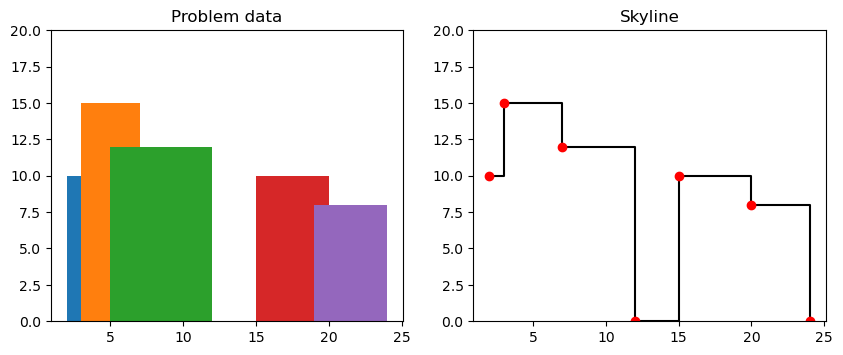

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots with equal width
fig, axs = plt.subplots(1, 2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1]})

# Create the first subplot to show the problem data as colored filled rectangles
for building in example_buildings:
 left, right, height = building
 axs[0].fill([left, right, right, left], [0, 0, height, height])

axs[0].set_ylim([0, 20])
axs[0].set_aspect('equal')
axs[0].set_title('Problem data')

# Create the second subplot to plot the skyline as a staircase function
x = [x for x, _ in example_skyline]
y = [y for _, y in example_skyline]

axs[1].step(x, y, where='post', color='black')

# Add the solution points as red dots
axs[1].plot(x, y, 'ro')

axs[1].set_ylim([0, 20])
axs[1].set_aspect('equal')
axs[1].set_title('Skyline')

plt.show()


## Algorithmes à implanter

On vous demande de résoudre ce problème de 3 façons différentes :

1. En utilisant un algorithme force brute simple ;
2. En utilisant un algorithme diviser pour régner ;
3. En utilisant un algorithme diviser pour régner avec seuil de récursivité non élémentaire.

Pour l’algorithme 3, vous devrez déterminer un seuil de récursivité expérimentalement. Les exemplaires dont la taille est en deçà de ce seuil ne sont plus résolus récursivement mais plutôt directement avec l’algorithme 1.

Vos algorithmes doivent donner des réponses où les couples `(x, h)` sont triés de façon non décroissante selon x (cf. exemple plus haut). Par ailleurs, ils ne doivent pas donner de solutions avec couples redondants, i.e. deux couples qui se suivent ne peuvent pas avoir la même hauteur ni la même abscisse. 


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [5]:
import random

max_width = 50
max_dist = 30
max_height = 300

def generate_sample(size):
    sample = []
    last_l = 0
    for _ in range(size):
        l = random.randint(last_l, last_l + max_dist)
        r = random.randint(l+1, l + max_width)
        h = random.randint(1, max_height)
        sample.append((l, r, h))
        last_l = l
    return sample

def get_dataset(seed, sizes):
    random.seed(seed)  
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [6]:
import time
from scipy.stats import linregress

def verification_plot(buildings, skyline):
    # Create a figure and a set of subplots with equal width
    fig, ax = plt.subplots(figsize=(10,5))

    # Create the first subplot to show the problem data as colored filled rectangles
    for building in buildings:
        left, right, height = building
        ax.fill([left, right, right, left], [0, 0, height, height])

    # Create the second subplot to plot the skyline as a staircase function
    x = [x for x, _ in skyline]
    y = [y for _, y in skyline]
    ax.step(x, y, where='post', color='black')

    # Add the solution points as red dots
    ax.plot(x, y, 'ro')

    plt.show()


def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        solution, compute_time = measure(procedure, sample)
        total_time += compute_time
       # print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()
    

def display_mesures_seuil(vals):
    x = list(vals.keys())
    y = list(vals.values())
    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Seuil')
    plt.ylabel('Temps')
    plt.title('Selection du seuil')
    plt.show()

## Partie 1 : Algorithme naïf (brute force) (5 pts)

### Implantation

<u>**Question 1.a):**</u> Implantez un algorithme naïf pour le problème de la ligne d'horizon.

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

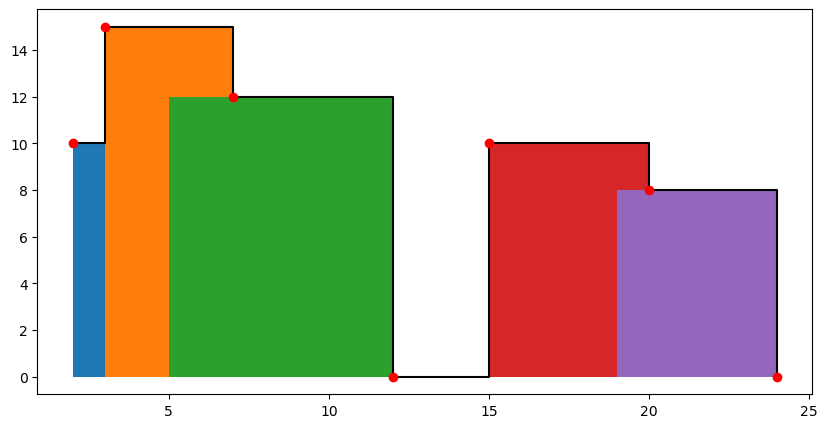

In [7]:
# Problem data
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]

# Solution data
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)]
#implement the skyline algorithm the bruteforce way
def skyline_bruteforce(buildings):
    points = []
    skyline = []
    last_height = 0
    for left, right, _ in buildings:
        points.append(left)
        points.append(right)
    points.sort()
    for point in points:
        height = 0
        for l, r, h in buildings:
            if l <= point < r:
                height = max(height, h)
        if height != last_height:
            skyline.append((point, height))
            last_height = height
    return skyline

verification_plot(example_buildings, skyline_bruteforce(example_buildings))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

### Mesures

In [8]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
dataset = get_dataset(2152269, [5,6,7,8,9,10,11,12,13,14,15,16])
dataset

{5: [[(4, 52, 196),
   (30, 77, 156),
   (45, 92, 5),
   (65, 114, 186),
   (76, 113, 288)],
  [(19, 36, 7), (26, 36, 73), (49, 91, 61), (72, 83, 126), (98, 123, 17)],
  [(1, 8, 195), (15, 44, 241), (36, 71, 216), (59, 71, 203), (76, 95, 246)],
  [(16, 18, 286), (33, 46, 143), (54, 87, 18), (57, 98, 70), (65, 105, 158)],
  [(0, 30, 154), (29, 47, 266), (44, 79, 293), (69, 115, 99), (84, 107, 21)]],
 6: [[(7, 14, 174),
   (22, 37, 276),
   (32, 74, 37),
   (43, 48, 250),
   (49, 57, 209),
   (53, 86, 171)],
  [(21, 31, 106),
   (46, 77, 33),
   (52, 55, 136),
   (79, 115, 170),
   (95, 102, 100),
   (117, 132, 228)],
  [(25, 65, 294),
   (43, 65, 56),
   (69, 103, 139),
   (76, 104, 18),
   (78, 84, 83),
   (95, 106, 275)],
  [(0, 49, 275),
   (3, 36, 9),
   (22, 39, 120),
   (50, 93, 244),
   (70, 73, 61),
   (81, 121, 225)],
  [(6, 46, 15),
   (19, 33, 168),
   (44, 67, 262),
   (55, 71, 25),
   (81, 119, 12),
   (107, 132, 5)]],
 7: [[(4, 27, 298),
   (27, 63, 212),
   (46, 49, 110),

In [9]:
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)

Représentez vos mesures sous forme d'un tableau avec la fonction `display_measures_table`.

In [10]:
display_measures_table(measures_bruteforce)

Taille       Temps moyen (s)
5            0.0         
6            0.0         
7            0.0         
8            0.0         
9            0.00019993782043457032
10           0.0         
11           0.0         
12           0.0         
13           0.0002002716064453125
14           0.0         
15           0.00020012855529785156
16           0.0014002799987792968


### Analyse hybride

#### Test de puissance

<u>**Question 2.a):**</u> Effectuez le test de puissance de votre algorithme.

Pour cela complétez d'abord le code de la fonction `values_test_puissance` pour obtenir les valeurs à placer sur le graphe. Utilisez ensuite la fonction `display_test_puissance` pour afficher le graphe.

In [11]:
import math

def values_test_puissance(measures):
    return {
        # TODO: calculez les valeurs x:y pour le test de puissance
        math.log(size) : math.log(measure)
        for size, measure in measures.items() 

    }

display_test_puissance(values_test_puissance(measures_bruteforce), "Test de puissance: algorithme naïf")
measures_bruteforce


ValueError: math domain error

<u>**Question 2.b):**</u> Analysez le graphe obtenu pour le test de puissance.

Le graphique obtenu est le graphique de log(temps) en fonction du log(taille). On peut voir que la courbe est une droite, ce qui signifie que c'est une consommation en temps qui croit de manière polynomiale avec la taille des exemplaires. La fonction de la droite obtenue est log(temps) = 2*log(taille) - 16.42, ce qui signifie qu'on a un m = 2. Puisqu'on a fait un graphique log(temps) en fonction du log(taille) et que le résultat qu'on obtient est une droite, on peut en conclure que la pente de la droite(m) représente le degré du polynôme qui représente la complexité de l'algorithme. Donc, notre hypothèse est que notre fonction f(x) = x², avec x représentant la taille des exemplaires.

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_rapport` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_rapport` pour afficher le graphe.

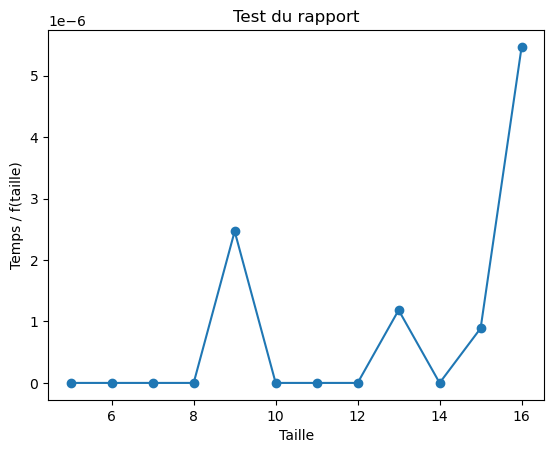

In [12]:
def values_test_rapport(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        size : (measure / f(size))
        for size, measure in measures.items()
    }

# TODO: definissez f judicieusement
def f(x):
    return x**2

display_test_rapport(values_test_rapport(measures_bruteforce, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport. Précisez le critère de choix de votre ou vos fonctions.

Le graphique obtenue est le graphique du temps / f(taille) en fonction de la taille. La fonction f(taille) est celle que nous avons déterminé à l'aide du test de puissance. On peut voir avec le graphique que la courbe obtenue converge vers une certaine valeur a ( ̃= 8.1 * 10⁻⁸) qui est plus grande que 0. C'est bien le résultat attendu qui nous confirme que notre hypothèse posé dans la question 2.b) est juste. On peut alors rafiné notre hypothèse en disant que temps = a * f(taille).

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Complétez d'abord la fonction `values_test_constantes` permettant d'obtenir les valeurs à reporter sur le graphe. Puis utilisez la fonction `display_test_constantes` pour afficher le graphe.

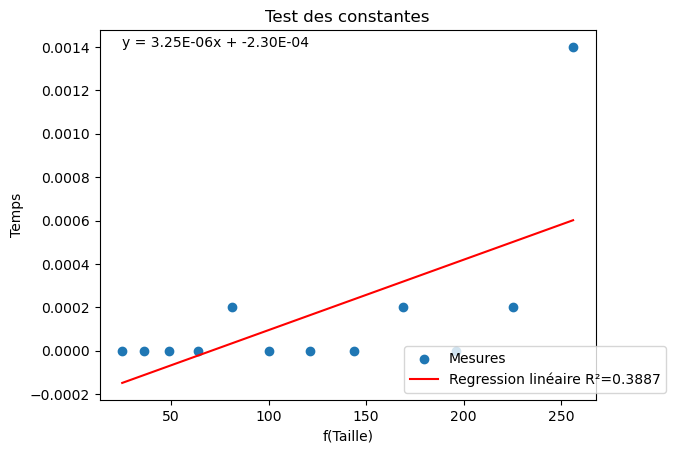

In [13]:
def values_test_constantes(measures, f):
    return {
        # TODO: calculez les valeurs x:y pour le test du rapport
        f(size) : measure
        for size, measure in measures.items()
    }

# TODO: définissez f judicieusement
def f(x):
    return x**2

display_test_constantes(values_test_constantes(measures_bruteforce, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Le graphique obtenue est le graphique du temps en fonction de la f(taille). Le graphique donne une droite, ce qui était le résultat attendu. La pente de la droite est supposé donner a et à la question précédente, nous avons trouvé que a est environ égale à 8.1 * 10⁻⁸. La pente du graphique nous donne 8.18 * 10⁻⁸, ce qui est très proche de la valeur de a trouvé au dernier numéro. On peut donc conclure que a est la constante de notre algorithme. Nous avons aussi une valeur d'ordonné à l'origine b qui est égale à -5.45 * 10⁻².


## Partie 2 : Algorithme diviser pour régner (5 pts)


<u>**Question 1.a):**</u> Implantez un algorithme pour le problème de la ligne d'horizon utlisant le patron de conception "Diviser pour régner".

Utilisez la fonction `verification_plot` sur l'exemplaire de présentation du problème `example_buildings` pour vérifier l'exactitude de votre algorithme et laissez la figure dans votre rapport.

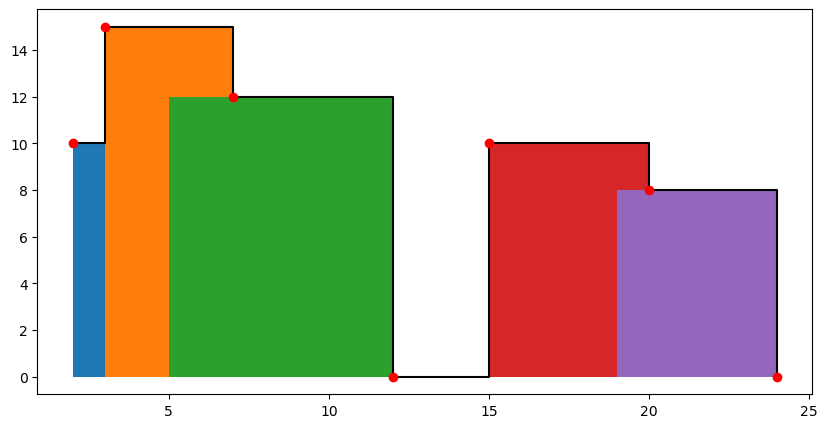

In [14]:

def skyline_divide_and_conquer(buildings):
    output = []
    skyline = []
    i, j = 0,0

    skyline_height_a, skyline_height_b = 0, 0

    if len(buildings) == 1:
        l, r, h = buildings[0]
        return [(l, h), (r, 0)]
    
    half = len(buildings)//2

    skyline_a = skyline_divide_and_conquer(buildings[:half])
    skyline_b = skyline_divide_and_conquer(buildings[half:])

    while i < len(skyline_a) or j < len(skyline_b):
        x_a, h_a = skyline_a[i] if i < len(skyline_a) else (float('inf'), 0)
        x_b, h_b = skyline_b[j] if j < len(skyline_b) else (float('inf'), 0)

        if x_a < x_b:
            skyline_height_a = h_a
            x = x_a
            i += 1
        if x_b <= x_a: 
            skyline_height_b = h_b
            x = x_b
            j += 1
        skyline.append((x, max(skyline_height_a, skyline_height_b)))
    last_height = 0

    for x, h in skyline:
        if h != last_height:
            output.append((x, h))
            last_height = h
    return output
example_buildings = [(2, 9, 10), (3, 7, 15), (5, 12, 12), (15, 20, 10), (19, 24, 8)]
example_skyline = [(2, 10), (3, 15), (7, 12), (12, 0), (15, 10), (20, 8), (24, 0)] 
verification_plot(example_buildings, skyline_divide_and_conquer(example_buildings))

<u>**Question 1.b):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

### Mesures (seuil 1)

In [62]:
# TODO: Utilisez un de vos matricules comme graine et une liste de tailles judicieusement choisies
liste=[20,21,22,23,24,25,25,26,27,28,29,30,31,32,33,34]
for i in range(len(liste)):
    liste[i]+=100

dataset = get_dataset(2144744, liste)
print(liste)

[120, 121, 122, 123, 124, 125, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]


In [16]:
measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer, dataset)
measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)


In [ ]:

from random import randint
#print("divide and conquer")
#display_measures_table(measures_divide_naive_threshold)
#print("bruteforce")
#display_measures_table(measures_bruteforce)
moyenne_divide=0
moyenne_brute=0
nbIterations=0
liste_moyenne=[]
random_number=randint(2000000,3000000)
while nbIterations<100:
    dataset = get_dataset(random_number, liste)
    measures_divide_naive_threshold = measure_procedure(skyline_divide_and_conquer, dataset)
    measures_bruteforce = measure_procedure(skyline_bruteforce, dataset)
    moyenne_divide=0
    moyenne_brute=0
    for index in liste:
        moyenne_divide+=measures_divide_naive_threshold[index]
        moyenne_brute+=measures_bruteforce[index]
    moyenne_divide/=len(liste)
    moyenne_brute/=len(liste)
    for i in range(len(liste)):
        liste[i]-=1
    if moyenne_brute<moyenne_divide:
            liste_moyenne.append(sum(liste)/len(liste))
            random_number=randint(2000000,3000000)
            liste=[100,101,102,103,104,105,106,107,108,109,110,111,112,113]
            nbIterations+=1


moyenne_resultante=sum(liste_moyenne)/len(liste_moyenne)
print("La moyenne resultante obtenue est:" + str(moyenne_resultante))


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

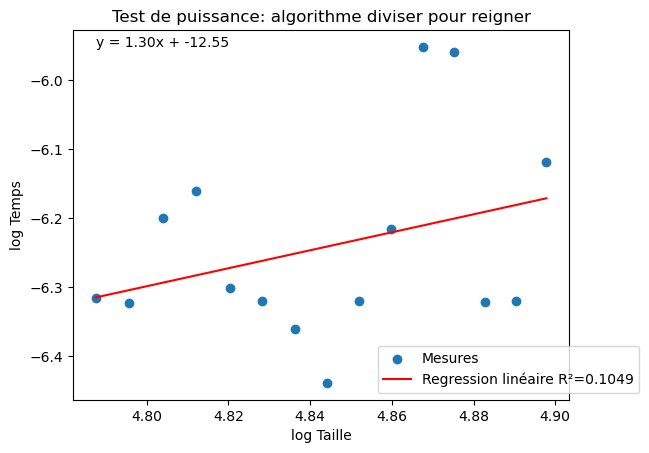

In [17]:
display_test_puissance(values_test_puissance(measures_divide_naive_threshold), "Test de puissance: algorithme diviser pour reigner")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

Le graphique obtenu est le graphique de log(temps) en fonction du log(taille). On peut voir que la courbe est une droite, ce qui signifie que c'est une consommation en temps qui croit de manière polynomiale avec la taille des exemplaires. La fonction de la droite obtenue est log(temps) = 1.05*log(taille) - 12.1, ce qui signifie qu'on a un m ̃= 1. Puisqu'on a fait un graphique log(temps) en fonction du log(taille) et que le résultat qu'on obtient est une droite, on peut en conclure que la pente de la droite(m) représente le degré du polynôme qui représente la complexité de l'algorithme. Donc, notre hypothèse est que notre fonction f(x) = x, avec x représentant la taille des exemplaires.

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

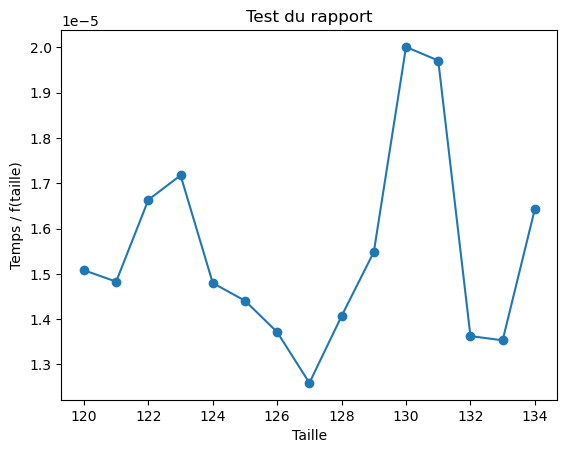

In [18]:
# TODO: définissez f judicieusement
def f(x):
    return x

display_test_rapport(values_test_rapport(measures_divide_naive_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

Le graphique obtenue est le graphique du temps / f(taille) en fonction de la taille. La fonction f(taille) est celle que nous avons déterminé à l'aide du test de puissance. On peut voir avec le graphique que la courbe obtenue converge vers une certaine valeur a ( ̃= 0.92 * 10⁻⁵) qui est plus grande que 0. C'est bien le résultat attendu qui nous confirme que notre hypothèse posé dans la question 3 est juste. On peut alors rafiné notre hypothèse en disant que temps = a * f(taille).

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

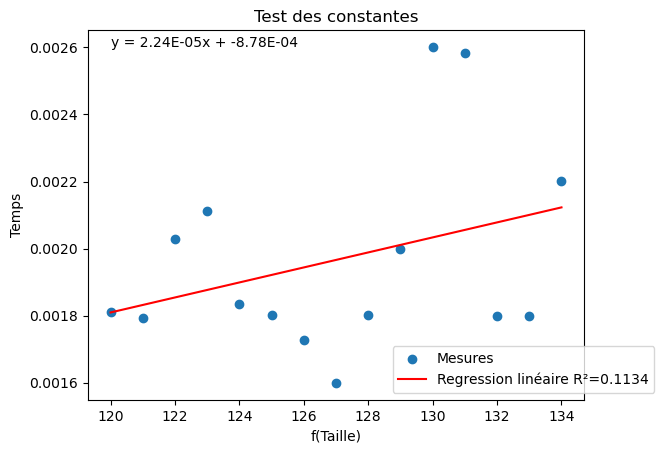

In [19]:
# TODO: définissez f judicieusement
def f(x):
    return x

display_test_constantes(values_test_constantes(measures_divide_naive_threshold, f))

<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

Le graphique obtenue est le graphique du temps en fonction de la f(taille). Le graphique donne une droite, ce qui était le résultat attendu. La pente de la droite est supposé donner a et à la question précédente, nous avons trouvé que a est environ égale à 0.92 * 10⁻⁵. La pente du graphique nous donne 0.935 * 10⁻⁵, ce qui est très proche de la valeur de a trouvé au dernier numéro. On peut donc conclure que a est la constante de notre algorithme. Nous avons aussi une valeur d'ordonné à l'origine b qui est égale à -5.32 * 10⁻³.

## Partie 3 : Algorithme diviser pour régner (seuil arbitraire) (5 pts)

### Selection du seuil

<u>**Question 1.a):**</u> Modifiez l'algorithme précédent pour y ajouter un seuil de récursivité (e.g. `threshold`). En dessous de ce seuil, vous utiliserez l'algorithme naïf écrit précédemment.

In [68]:
def skyline_divide_and_conquer_threshold(buildings, threshold):
    if len(buildings)<threshold:
        return skyline_bruteforce(buildings)
    else:
        return skyline_divide_and_conquer(buildings)


<u>**Question 1.b):**</u> Effectuez les mesures avec plusieurs seuils de récursivité pour déterminer le seuil le plus judicieux.

In [69]:
liste=[50000]
dataset = get_dataset(2144742, liste)

measures_threshold = {
    i:
    measure_mean_time(
        lambda sample: skyline_divide_and_conquer_threshold(sample, i),
        [dataset[50000][0]]) # TODO: sélectionnez un exemplaire 
        for i in [10,20,30,40,50,60,70,80,90,100] # TODO: testez une liste judicieuse de seuils
}


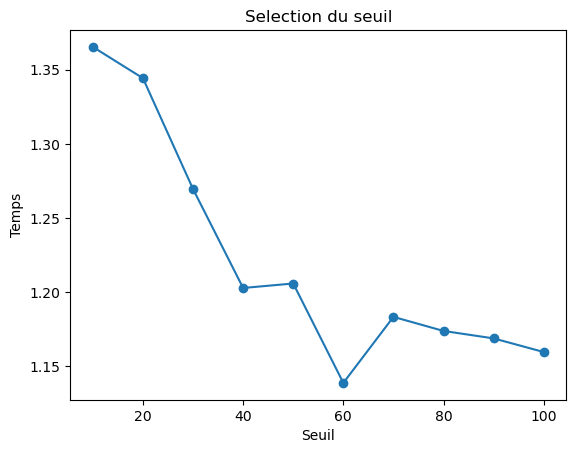

In [71]:
display_mesures_seuil(measures_threshold)


# <u>**Question 1.c):**</u> Quel est le seuil de récursivité de le plus judicieux ? Sur quel critère l'avez vous sélectionné ? Pourquoi des seuils inférieurs ou supérieurs donnent-ils de moins bonnes performances ?

Le seuil de récursivité suggéré par le graphique est d'environ 40. Cependant, il faut prendre ces valeurs avec des pincettes comme l'ordinateur possède une capacité qui varie, et que l'on a pas fait varier le seed pour les graphiques. Selon l'algorithme que nous avons réalisé précédemment, le seuil semble être d'environ 63. Ce seuil là est proche du seuil que nous avons avec le graphique de 60. Nous avons aussi changé le seed quelque fois avec les graphiques pour voir le minimum obtenu. Et nous avons réalisé qu'il oscillait entre 0 et 100. 
Comme cette méthode d'évaluation est moins précise que celle que nous avons fait, alors nous pouvons avec assurance établir que le threshold optimal est de 63 tel que déterminé précédemment. 

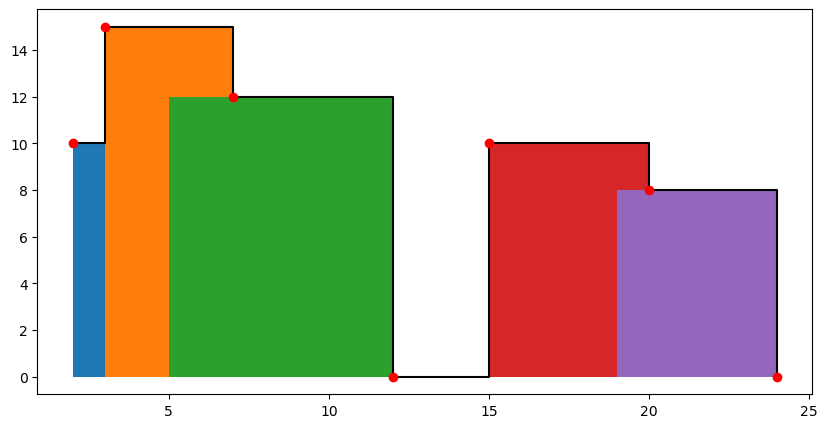

In [81]:
best_threshold = 63
verification_plot(example_buildings, skyline_divide_and_conquer_threshold(example_buildings, best_threshold))

<u>**Question 1.d):**</u> Quelle est la complexité asymptotique théorique de cet algorithme?

### Mesures (seuil n)

In [127]:
liste=[30,40,50,60,70,80,100,200,300,400,500,600,700, 1000,2000,3000,4000,5000,6000,10000,11000,12000,13000,14000]
dataset = get_dataset(2144742, liste)
measures_divide_best_threshold = measure_procedure(lambda sample : skyline_divide_and_conquer_threshold(sample, best_threshold), dataset)

In [128]:
display_measures_table(measures_divide_best_threshold)

Taille       Temps moyen (s)
30           0.00020213127136230468
40           0.0003994941711425781
50           0.0006000995635986328
60           0.0009999275207519531
70           0.0008007526397705078
80           0.0009992599487304687
100          0.0012000560760498046
200          0.0023995399475097655
300          0.004603910446166992
400          0.006418991088867188
500          0.008198213577270509
600          0.0106536865234375
700          0.012218332290649414
1000         0.018401050567626955
2000         0.03415141105651855
3000         0.051721382141113284
4000         0.0785304069519043
5000         0.10691351890563965
6000         0.11962594985961914
10000        0.19896106719970702
11000        0.24125490188598633
12000        0.25084667205810546
13000        0.2725216865539551
14000        0.31020255088806153


### Analyse hybride

#### Test de puissance

Effectuez le test de puissance de votre algorithme.

Utilisez la fonction `display_test_puissance` pour afficher le graphe.

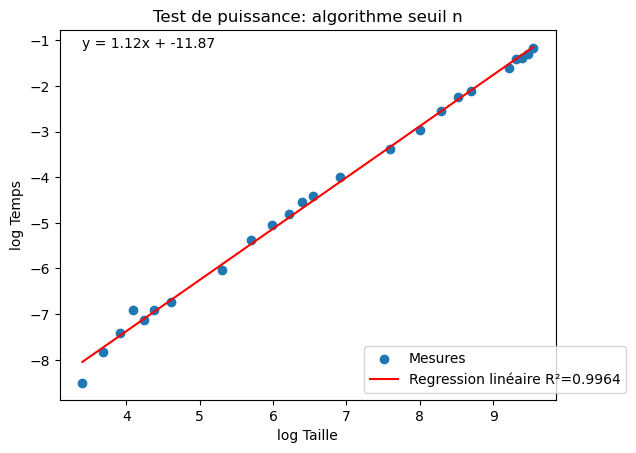

In [129]:
display_test_puissance(values_test_puissance(measures_divide_best_threshold), "Test de puissance: algorithme seuil n")

<u>**Question 2):**</u> Analysez le graphe obtenu pour le test de puissance.

En analysant ce graphe on réalise qu'on obtient une droite. Ainsi, On voit bien qu'il y a une relation polynomiale, comme on avait log(temps) en ordonnée et log(taille ) en abscisse. 
Cela donne ainsi temps=taille^n puisque log(temps)=mlog(taille)
Or là, on a un coefficient directeur de 1.12. Cela est intéressant puisqu'il est supérieur à 1 mais reste inférieur à 2.
Cela suggère donc que notre relation polynomiale n'est pas n^2, mais pas non plus n. Un peu plus, ou en d'autre mots, un entre deux entre une puissance de 1 et 2. Analysons les prochains graphiques pour s'en assurer. 

#### Test du rapport

<u>**Question 3.a):**</u> Effectuez le test du rapport avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_rapport` pour afficher le graphe.

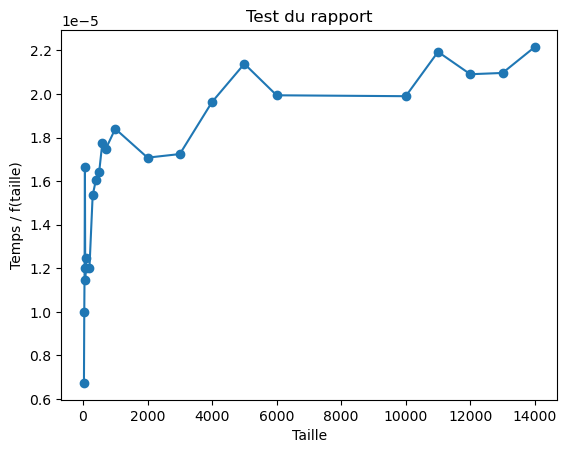

In [130]:
# TODO: définissez f judicieusement
def f(x):
    return x

display_test_rapport(values_test_rapport(measures_divide_best_threshold, f))

<u>**Question 3.b):**</u> Analysez le graphe obtenu pour le test du rapport.

On réalise que lorsque la taille tend vers l'infini, on obtient un ratio de temps/taille qui devient reste le même. Cela suggère ainsi que l'on a une relation linéaire comme la variation du temps / variation de la taille donne une valeur à peu près constante. On en déduit que l'on est proche du n log n, puisque si on avait log n, on aurait que le ratio du temps sur la taille tendrait vers 0. Or, là il reste constant, ce qui veut dire en intégrant que l'on obtient bien une variable.
Cela fait du sens comme la relation log n tend à stagner lorsque n tend vers infini. 

### Test des constantes

<u>**Question 4.a):**</u> Effectuez le test des constantes avec une ou plusieurs fonctions f pertinentes.

Utilisez la fonction `display_test_constantes` pour afficher le graphe.

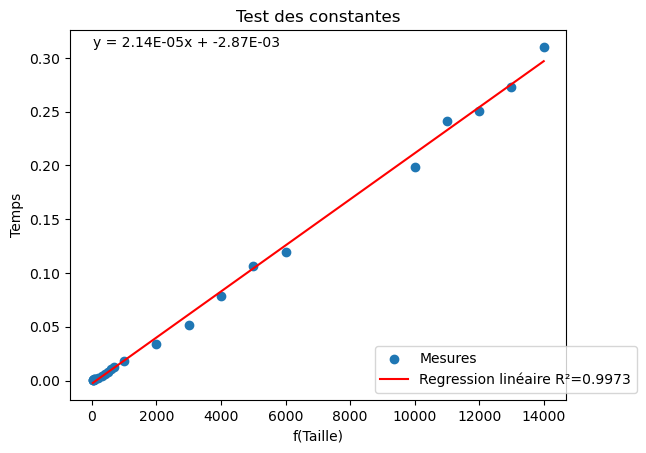

In [131]:
# TODO: définissez f judicieusement
def f(x):
    return x

display_test_constantes(values_test_constantes(measures_divide_best_threshold, f))


<u>**Question 4.b):**</u> Analysez le graphe obtenu et indiquez les valeurs des constantes mises en évidence par le test.

On obtient une relation qui est bel et bien linéaire tel que l'on avait prédit. Cela contribue a confirmer que l'on obtient n log n, asymptotiquement. 

<u>**Question 5):**</u> Commentez l'impact du seuil de récursivité. Que représente t'il pour l'algorithme diviser pour régner et l'algorithme naïf ?

On réalise ainsi que l'impact du seuil de récursivité est de permettre de maintenir des performances optimales peu importe la taille de l'échantillon et de prendre avantage des différents algorithmes que l'on a et des tailles auxquelles ils performent le mieux. 
On a ainsi évité d'obtenir une complexité de probablement n^2 avec l'algorithme brute en établissant un seuil qui fait en sorte d'utiliser l'algorithme de diviser pour régner lorsqu'il n'est plus profitable d'utiliser l'algo brute. 
Cependant, nous avons aussi fait attention à ne pas seulement utiliser l'algorithme diviser pour régner comme la courbe n log n tend à être plus élevée que celle de n^2 pour des n inférieurs à un seuil donné (qu'il est possible de trouver en posant une équation et qui oscille autour de 1.15). 

# Conclusion (3 pts)

Résumez *brièvement* vos découvertes et analyses, et indiquez dans quelles circonstances vous utiliserez chacun de ces 3 algorithmes.

On a ainsi découvert que l'algorithme brut que l'on a utilisé précédemment a des performances moins bonnes que celui de diviser pour régner lorsque la taille des sample que l'on a dépasse un certain seuil, que l'on a trouvé par le biais de l'expérimentation et de génération de graphiques de performances en faisant varier les seuils. 
On a cependant aussi découvert que l'algorithme brut possède un avantage par rapport à celui de diviser pour régner lorsque n est inférieur au seuil que l'on a trouvé. 
Ainsi, ces deux algorithmes semblent être utiles et il ne faut pas en garder un au profit de l'autre sans réfléchir à une manière d'avoir la meilleur performance peu importe la taille. 
C'est ce que l'on a fait dans la dernière partie en trouvant un algorithme hybride qui fait en sorte d'utiliser les deux algorihtmes en fonction de la taille des exemplaires que l'on a à partir du seuil que l'on a trouvé 
Cela a fait en sorte que l'on a atteint la meilleur performance pour le problème de la skyline et que l'on a optimisé les temps du mieux qu'il était possible avec les 2 algorithmes que l'on a trouvé: l'un brut, tendant vers n^2 à cause des boucles while utilisées, et l'autre diviser pour reigner, qui dans notre cas s'avère tendre vers n log n (ce que l'on a remarqué par le biais d'expérimentaiton et d'écriture de rapports de variables, et de tests polynomiaux). 



 ## Autres critères (2 pts)
 Qualité du code / 1 pt

Présentation générale / 1 pt

- Concision
- Qualité du français

Pénalité retard
- -1 pt / journée de retard, arrondi vers le haut. Les TPs ne sont plus acceptés après 3 jours.